# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt


from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    StandardScaler
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer, TfidfTransformer
)
from sklearn.datasets import fetch_20newsgroups

In [2]:
# Algumas configurações para o matplotlib.
# %matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

## Countries DataSet

In [3]:
countries = pd.read_csv("countries.csv")

In [4]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


### Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

In [5]:
np.sort(countries["Region"].unique())

array(['ASIA (EX. NEAR EAST)         ',
       'BALTICS                            ', 'C.W. OF IND. STATES ',
       'EASTERN EUROPE                     ', 'LATIN AMER. & CARIB    ',
       'NEAR EAST                          ',
       'NORTHERN AFRICA                    ',
       'NORTHERN AMERICA                   ',
       'OCEANIA                            ',
       'SUB-SAHARAN AFRICA                 ',
       'WESTERN EUROPE                     '], dtype=object)

In [6]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
Country             227 non-null object
Region              227 non-null object
Population          227 non-null int64
Area                227 non-null int64
Pop_density         227 non-null object
Coastline_ratio     227 non-null object
Net_migration       224 non-null object
Infant_mortality    224 non-null object
GDP                 226 non-null float64
Literacy            209 non-null object
Phones_per_1000     223 non-null object
Arable              225 non-null object
Crops               225 non-null object
Other               225 non-null object
Climate             205 non-null object
Birthrate           224 non-null object
Deathrate           223 non-null object
Agriculture         212 non-null object
Industry            211 non-null object
Service             212 non-null object
dtypes: float64(1), int64(2), object(17)
memory usage: 35.5+ KB


In [7]:
for col in new_column_names:
    try:
        countries[col] = countries[col].str.strip()  # trim leading spaces
        countries[col] = countries[col].str.replace(',','.').astype(float)
    except:
        pass


A transformação pode ser constatada com

In [8]:
countries.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


In [9]:
np.sort(countries["Region"].unique())

array(['ASIA (EX. NEAR EAST)', 'BALTICS', 'C.W. OF IND. STATES',
       'EASTERN EUROPE', 'LATIN AMER. & CARIB', 'NEAR EAST',
       'NORTHERN AFRICA', 'NORTHERN AMERICA', 'OCEANIA',
       'SUB-SAHARAN AFRICA', 'WESTERN EUROPE'], dtype=object)

In [10]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
Country             227 non-null object
Region              227 non-null object
Population          227 non-null int64
Area                227 non-null int64
Pop_density         227 non-null float64
Coastline_ratio     227 non-null float64
Net_migration       224 non-null float64
Infant_mortality    224 non-null float64
GDP                 226 non-null float64
Literacy            209 non-null float64
Phones_per_1000     223 non-null float64
Arable              225 non-null float64
Crops               225 non-null float64
Other               225 non-null float64
Climate             205 non-null float64
Birthrate           224 non-null float64
Deathrate           223 non-null float64
Agriculture         212 non-null float64
Industry            211 non-null float64
Service             212 non-null float64
dtypes: float64(16), int64(2), object(2)
memory usage: 35.5+ KB


### Análise

O data_set conta com 20 variáveis de 227 países, sendo
* 2 variáveis `object` (string)
* 2 variáveis `int64`
* 16 variáveis `float64`


As variáveis faltantes por categoria são:

In [11]:
countries.isna().sum()

Country              0
Region               0
Population           0
Area                 0
Pop_density          0
Coastline_ratio      0
Net_migration        3
Infant_mortality     3
GDP                  1
Literacy            18
Phones_per_1000      4
Arable               2
Crops                2
Other                2
Climate             22
Birthrate            3
Deathrate            4
Agriculture         15
Industry            16
Service             15
dtype: int64

As quantidades de valores únicos por categoria são:

In [12]:
countries.nunique()

Country             227
Region               11
Population          227
Area                226
Pop_density         219
Coastline_ratio     151
Net_migration       157
Infant_mortality    220
GDP                 130
Literacy            140
Phones_per_1000     214
Arable              203
Crops               162
Other               209
Climate               6
Birthrate           220
Deathrate           201
Agriculture         150
Industry            155
Service             167
dtype: int64

A descrição estatística das variáveis numéricas é:

In [13]:
countries.describe()

,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
count,2.270000e+02,2.270000e+02,227.000000,227.000000,224.000000,224.000000,226.000000,209.000000,223.000000,225.000000,225.000000,225.000000,205.000000,224.000000,223.000000,212.000000,211.000000,212.000000
mean,2.874028e+07,5.982270e+05,379.047137,21.165330,0.038125,35.506964,9689.823009,82.838278,236.061435,13.797111,4.564222,81.638311,2.139024,22.114732,9.241345,0.150844,0.282711,0.565283
std,1.178913e+08,1.790282e+06,1660.185825,72.286863,4.889269,35.389899,10049.138513,19.722173,227.991829,13.040402,8.361470,16.140835,0.699397,11.176716,4.990026,0.146798,0.138272,0.165841
min,7.026000e+03,2.000000e+00,0.000000,0.000000,-20.990000,2.290000,500.000000,17.600000,0.200000,0.000000,0.000000,33.330000,1.000000,7.290000,2.290000,0.000000,0.020000,0.062000
25%,4.376240e+05,4.647500e+03,29.150000,0.100000,-0.927500,8.150000,1900.000000,70.600000,37.800000,3.220000,0.190000,71.650000,2.000000,12.672500,5.910000,0.037750,0.193000,0.429250
50%,4.786994e+06,8.660000e+04,78.800000,0.730000,0.000000,21.000000,5550.000000,92.500000,176.200000,10.420000,1.030000,85.700000,2.000000,18.790000,7.840000,0.099000,0.272000,0.571000
75%,1.749777e+07,4.418110e+05,190.150000,10.345000,0.997500,55.705000,15700.000000,98.000000,389.650000,20.000000,4.440000,95.440000,3.000000,29.820000,10.605000,0.221000,0.341000,0.678500
max,1.313974e+09,1.707520e+07,16271.500000,870.660000,23.060000,191.190000,55100.000000,100.000000,1035.600000,62.110000,50.680000,100.000000,4.000000,50.730000,29.740000,0.769000,0.906000,0.954000


O clima está rotulado em 6 categorias, sendo que alguns dados não se encontram em nenhuma delas.

In [14]:
countries['Climate'].value_counts()

2.0    111
3.0     48
1.0     29
1.5      8
4.0      6
2.5      3
Name: Climate, dtype: int64

A distribuição por região é a seguinte

In [15]:
countries['Region'].value_counts()

SUB-SAHARAN AFRICA      51
LATIN AMER. & CARIB     45
WESTERN EUROPE          28
ASIA (EX. NEAR EAST)    28
OCEANIA                 21
NEAR EAST               16
C.W. OF IND. STATES     12
EASTERN EUROPE          12
NORTHERN AFRICA          6
NORTHERN AMERICA         5
BALTICS                  3
Name: Region, dtype: int64

### Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [16]:
def q1():
    return np.sort(countries["Region"].unique()).tolist()

In [17]:
# 
q1()

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

### Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [18]:
def q2():
    est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
    pop_density_10bins = est.fit_transform(countries[['Pop_density']])
    plt.hist(pop_density_10bins)
    above_90 = np.sum(pop_density_10bins >= 9)
    # (pop_density_10bins > np.percentile(pop_density_10bins, 90)).sum()
    return above_90

23

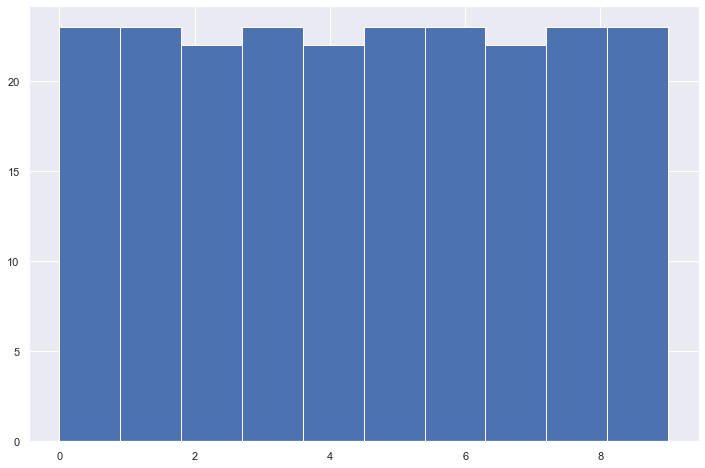

In [19]:
q2()

In [20]:
countries['Pop_density'].describe()

count      227.000000
mean       379.047137
std       1660.185825
min          0.000000
25%         29.150000
50%         78.800000
75%        190.150000
max      16271.500000
Name: Pop_density, dtype: float64

Sem a discretização, o histograma não era visual.

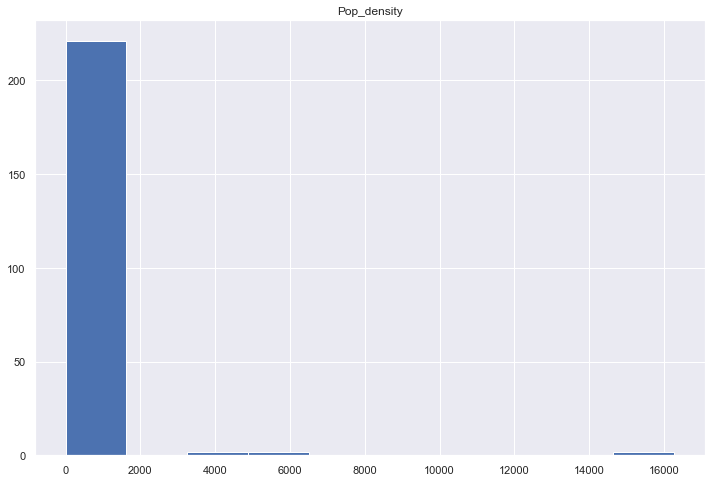

In [21]:
countries[['Pop_density']].hist();

Por causa dos outliers superiores

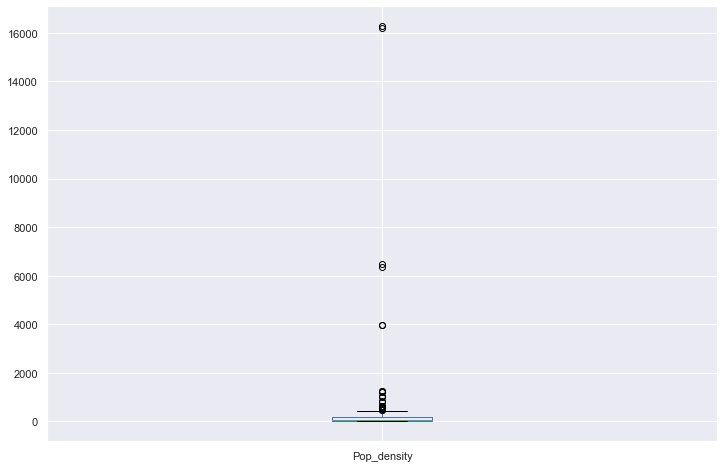

In [22]:
countries[['Pop_density']].boxplot();

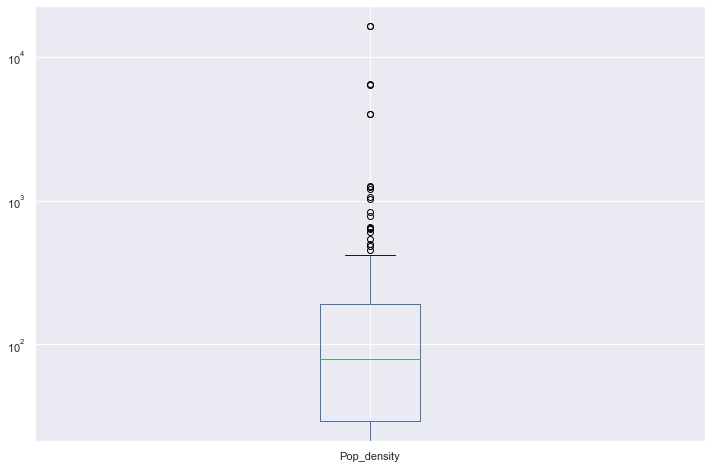

In [23]:
countries[['Pop_density']].plot(kind='box', logy=True);

### Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [24]:
def q3():
    
    enc = OneHotEncoder()
       
    climate_one_hot = enc.fit_transform(countries[['Climate']].astype('str'))
    # climate_one_hot = enc.fit_transform(countries[['Climate']].dropna())
    
    region_one_hot = enc.fit_transform(countries[['Region']])
    
    climate_old_n = countries['Climate'].nunique()
    region_old_n = countries['Region'].nunique()
    
    new_elements_climate = climate_one_hot.shape[1]
    new_elements_region = region_one_hot.shape[1]
    
    new_elements = new_elements_climate + new_elements_region
    
    return new_elements

In [25]:
q3()

18

#### Análises das etapas

In [26]:
enc = OneHotEncoder()
    
climate_one_hot = enc.fit_transform(countries[['Climate']].dropna())
region_one_hot = enc.fit_transform(countries[['Region']])
        
climate_old_n = countries['Climate'].nunique()
region_old_n = countries['Region'].nunique()
    
new_elements_climate = climate_one_hot.shape[1] - 1
new_elements_region = region_one_hot.shape[1] - 1
    
new_elements = new_elements_climate + new_elements_region
new_elements_climate
new_elements_region

10

In [27]:
climate_one_hot.shape[0] * climate_one_hot.shape[1] - len(countries['Climate'])

1003

In [28]:
new_elements = climate_one_hot.shape[0] * climate_one_hot.shape[1] - len(countries['Climate'])
new_elements = new_elements + region_one_hot.shape[0] * region_one_hot.shape[1] - len(countries['Region'])
new_elements

3273

In [29]:
climate_one_hot

<205x6 sparse matrix of type '<class 'numpy.float64'>'
	with 205 stored elements in Compressed Sparse Row format>

In [30]:
countries['Climate'].nunique()

6

In [31]:
countries['Region'].nunique()

11

In [32]:
region_one_hot 

<227x11 sparse matrix of type '<class 'numpy.float64'>'
	with 227 stored elements in Compressed Sparse Row format>

In [33]:
region_one_hot.toarray()[:10]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [34]:
enc.categories_[0]

array(['ASIA (EX. NEAR EAST)', 'BALTICS', 'C.W. OF IND. STATES',
       'EASTERN EUROPE', 'LATIN AMER. & CARIB', 'NEAR EAST',
       'NORTHERN AFRICA', 'NORTHERN AMERICA', 'OCEANIA',
       'SUB-SAHARAN AFRICA', 'WESTERN EUROPE'], dtype=object)

Em formato numérico não roda com NaN.

In [35]:
enc = OneHotEncoder()
climate_one_hot = enc.fit_transform(countries[['Climate']].dropna())
enc.categories_[0]

array([1. , 1.5, 2. , 2.5, 3. , 4. ])

Se converte em string para contabilizar NaN.

In [36]:
enc = OneHotEncoder()
climate_one_hot = enc.fit_transform(countries[['Climate']].astype('str'))
enc.categories_[0]

array(['1.0', '1.5', '2.0', '2.5', '3.0', '4.0', 'nan'], dtype=object)

In [37]:
print(countries['Climate'].unique())
len(countries['Climate'].unique())

[1.  3.  2.  nan 4.  1.5 2.5]


7

In [38]:
climate_one_hot.shape[1]

7

In [39]:
print(countries['Region'].unique())
len(countries['Region'].unique())

['ASIA (EX. NEAR EAST)' 'EASTERN EUROPE' 'NORTHERN AFRICA' 'OCEANIA'
 'WESTERN EUROPE' 'SUB-SAHARAN AFRICA' 'LATIN AMER. & CARIB'
 'C.W. OF IND. STATES' 'NEAR EAST' 'NORTHERN AMERICA' 'BALTICS']


11

In [40]:
region_one_hot.shape[1]

11

### Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [41]:
# Single sample as list
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [42]:
def q4():  #-1.047
    # Set the pipeline
    num_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("standard_scaler", StandardScaler())
    ])
    
    # Get list with numeric columns names from a dataframe
    names_numeric_col = countries.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Fit and transform the numeric subset of a dataframe with the numeric pipeline
    countries_transformed = num_pipeline.fit_transform(countries[names_numeric_col])
    
    # Discard the string entries from a list
    test_country_num_list = [x for x in test_country if not isinstance(x, str)]  # not select strings
    
    # Convert a single sample inputted as a list to sklearn input np.array
    test_country_num_np = np.asarray(test_country_num_list).reshape(1, -1)
    
    # Return index from Arable in the numeric subset
    idx_Arable = names_numeric_col.index('Arable')
    
    # Apply the pipeline transformation
    test_country_transformed = num_pipeline.transform(test_country_num_np)
    
    # Get transformed Arable entry in the required format
    arable_transformed = round(test_country_transformed[:,idx_Arable][0],3)
    return arable_transformed

In [43]:
q4()

-1.047

Mostrando as etapas:

In [44]:
# Set the pipeline
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("standard_scaler", StandardScaler())
])

In [45]:
# Get list with numeric columns names from a dataframe
names_numeric_col = countries.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [46]:
# Fit and transform the numeric subset of a dataframe with the numeric pipeline
countries_transformed = num_pipeline.fit_transform(countries[names_numeric_col])

In [47]:
# Discard the string entries from a list
test_country_num_list = [x for x in test_country if not isinstance(x, str)]  # not select strings
test_country_num_list

[-0.19032480757326514,
 -0.3232636124824411,
 -0.04421734470810142,
 -0.27528113360605316,
 0.13255850810281325,
 -0.8054845935643491,
 1.0119784924248225,
 0.6189182532646624,
 1.0074863283776458,
 0.20239896852403538,
 -0.043678728558593366,
 -0.13929748680369286,
 1.3163604645710438,
 -0.3699637766938669,
 -0.6149300604558857,
 -0.854369594993175,
 0.263445277972641,
 0.5712416961268142]

In [48]:
# Convert a single sample inputted as a list to sklearn input np.array
test_country_num_np = np.asarray(test_country_num_list).reshape(1, -1)
test_country_num_np

array([[-0.19032481, -0.32326361, -0.04421734, -0.27528113,  0.13255851,
        -0.80548459,  1.01197849,  0.61891825,  1.00748633,  0.20239897,
        -0.04367873, -0.13929749,  1.31636046, -0.36996378, -0.61493006,
        -0.85436959,  0.26344528,  0.5712417 ]])

In [49]:
# Return index from Arable in the numeric subset
idx_Arable = names_numeric_col.index('Arable')
idx_Arable

9

In [50]:
# Apply the pipeline transformation
test_country_transformed = num_pipeline.transform(test_country_num_np)
test_country_transformed

array([[-0.24432501, -0.33489095, -0.22884735, -0.29726002,  0.01959086,
        -1.02861728, -0.96623348, -4.35427242, -1.03720972, -1.04685743,
        -0.55058149, -5.10112169, -1.21812201, -2.02455164, -1.99092137,
        -7.04915046, -0.13915481,  0.03490335]])

In [51]:
# Get transformed Arable entry in the required format
arable_transformed = round(test_country_transformed[:,idx_Arable][0],3)
arable_transformed

-1.047

#### Análise da padronização

Para verificar o processo de normalização, poderia ser inspecionadas as variáveis média e desvio padrão, para ver se correspondem a nulas e unitárias para todas as variáveis numéricas.

In [52]:
countries.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


In [53]:
# data_transformed = countries.select_dtypes(exclude=['int64', 'float64']).copy()
df_countries_transformed = pd.DataFrame(countries_transformed, columns=names_numeric_col)

In [54]:
df_countries_transformed.head()

,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,0.019695,0.027583,-0.199844,-0.293443,4.750798,3.638098,-0.896394,-2.497817,-1.027491,-0.126361,-0.518861,0.372602,-1.694358,2.212967,2.252507,1.636576,-0.315406,-1.161135
1,-0.213877,-0.318797,-0.153603,-0.275974,-1.025097,-0.392850,-0.516718,0.151933,-0.726079,0.565115,-0.013604,-0.447933,1.316360,-0.627986,-0.809333,0.595163,-0.706318,0.083424
2,0.035618,0.998421,-0.220490,-0.292889,-0.088242,-0.122886,-0.366846,-0.713827,-0.695494,-0.813978,-0.515252,0.926276,-1.694358,-0.444844,-0.932859,-0.326627,2.390911,-1.673969
3,-0.243834,-0.334779,-0.053514,0.514709,-4.281389,-0.741696,-0.167016,0.702871,0.108568,-0.290741,1.259163,-0.416135,-0.188999,0.035113,-1.204213,-0.340700,-0.074844,0.033392
4,-0.243720,-0.334629,-0.137002,-0.293443,1.354184,-0.890347,0.932047,0.860282,1.162182,-0.891152,-0.545327,1.004214,1.316360,-1.205379,-0.600755,-0.340700,-0.074844,0.033392


In [55]:
df_countries_transformed.mean()

Population          2.579924e-17
Area                5.991292e-17
Pop_density         1.344984e-17
Coastline_ratio    -1.858523e-17
Net_migration      -1.307538e-17
Infant_mortality   -2.543242e-17
GDP                 2.445425e-17
Literacy           -1.180896e-15
Phones_per_1000     2.396517e-17
Arable              9.096982e-17
Crops               7.629727e-17
Other              -1.379220e-16
Climate             9.781701e-17
Birthrate          -4.939759e-17
Deathrate          -2.973637e-16
Agriculture         1.160354e-16
Industry           -2.562806e-16
Service             2.310927e-16
dtype: float64

In [56]:
df_countries_transformed.std()

Population          1.00221
Area                1.00221
Pop_density         1.00221
Coastline_ratio     1.00221
Net_migration       1.00221
Infant_mortality    1.00221
GDP                 1.00221
Literacy            1.00221
Phones_per_1000     1.00221
Arable              1.00221
Crops               1.00221
Other               1.00221
Climate             1.00221
Birthrate           1.00221
Deathrate           1.00221
Agriculture         1.00221
Industry            1.00221
Service             1.00221
dtype: float64

O processo de padronização permite comparar as features visualmente em um boxplot:

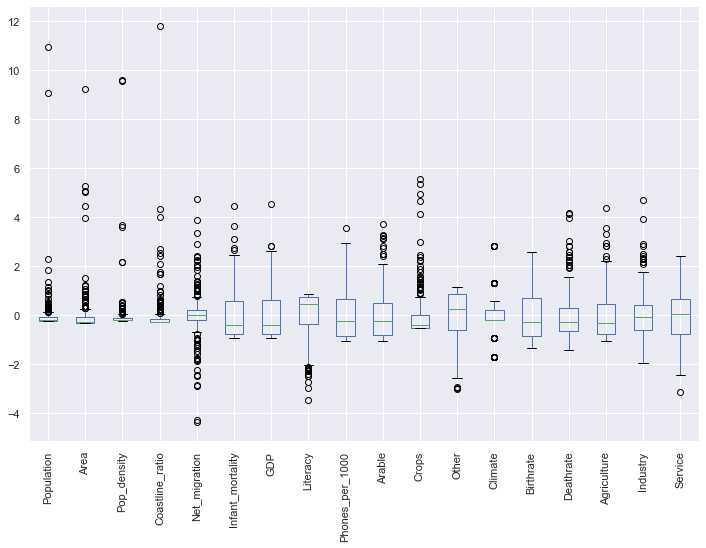

In [57]:
df_countries_transformed.boxplot(rot=90);

#### Comentário sobre o dado test_country

Faria mais sentido o input test_country se referir a um dado já transformado.
Por exemplo, o input fornecido conta com uma população negativa.

Como observado no plot abaixo, ele apresenta valores razoáveis para todas as variáveis numéricas.

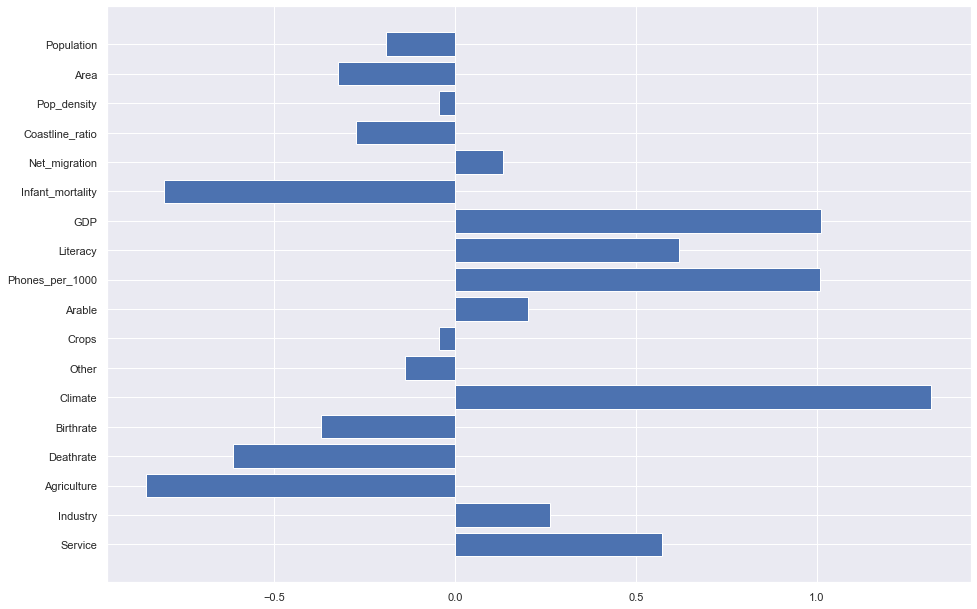

In [58]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(names_numeric_col,test_country_num_list)
plt.gca().invert_yaxis()

Caso fosse esse o caso, para aplicar a transformação inversa, o pipeline poderia ser reduzido à etapa de padronização.

Pois a imputação de NaN com mediana, não é inversível no sklearn.

In [59]:
# Set the pipeline
num_pipeline2 = Pipeline(steps=[
    ("standard_scaler", StandardScaler())
])

In [60]:
# Fit and transform the numeric subset of a dataframe with the numeric pipeline
countries_transformed_2 = num_pipeline2.fit_transform(countries[names_numeric_col])

E os dados se refeririam a um país com esses valores numéricos que, de fato, parecem razoáveis.

In [61]:
test_country_inv_transformed = num_pipeline2.inverse_transform(test_country_num_np)
dftest_country_inv_transformed = pd.DataFrame(test_country_inv_transformed, columns=names_numeric_col)
dftest_country_inv_transformed

,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,6352117.0,20770.0,305.8,1.31,0.684791,7.064647,19836.811188,95.015453,465.244487,16.430603,4.199816,79.394935,3.057434,17.988992,6.179716,0.025721,0.319052,0.659795


#### Formas alternativas

In [62]:
col_int_float_names = countries.select_dtypes(include=['int64', 'float64']).columns

imputed_countries = countries.copy()

for col in col_int_float_names:
    imputed_countries[col] = countries[col].fillna(countries[col].median())


In [63]:
countries.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


In [64]:
imputed_countries.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,0.099,0.272,0.571
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,0.099,0.272,0.571


In [65]:
# Create the Scaler object
scaler = StandardScaler()

scaled_countries = imputed_countries.copy()

for col in col_int_float_names:
    scaled_countries[[col]] = scaler.fit_transform(scaled_countries[[col]])
    

In [66]:
scaled_countries.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),0.019695,0.027583,-0.199844,-0.293443,4.750798,3.638098,-0.896394,-2.497817,-1.027491,-0.126361,-0.518861,0.372602,-1.694358,2.212967,2.252507,1.636576,-0.315406,-1.161135
1,Albania,EASTERN EUROPE,-0.213877,-0.318797,-0.153603,-0.275974,-1.025097,-0.392850,-0.516718,0.151933,-0.726079,0.565115,-0.013604,-0.447933,1.316360,-0.627986,-0.809333,0.595163,-0.706318,0.083424
2,Algeria,NORTHERN AFRICA,0.035618,0.998421,-0.220490,-0.292889,-0.088242,-0.122886,-0.366846,-0.713827,-0.695494,-0.813978,-0.515252,0.926276,-1.694358,-0.444844,-0.932859,-0.326627,2.390911,-1.673969
3,American Samoa,OCEANIA,-0.243834,-0.334779,-0.053514,0.514709,-4.281389,-0.741696,-0.167016,0.702871,0.108568,-0.290741,1.259163,-0.416135,-0.188999,0.035113,-1.204213,-0.340700,-0.074844,0.033392
4,Andorra,WESTERN EUROPE,-0.243720,-0.334629,-0.137002,-0.293443,1.354184,-0.890347,0.932047,0.860282,1.162182,-0.891152,-0.545327,1.004214,1.316360,-1.205379,-0.600755,-0.340700,-0.074844,0.033392


### Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

In [67]:
def quartile_boxplot(x):
    
    X = np.sort(x)
    
    n = len(X)
    median = np.median(X)
    
    if n % 2 != 0:  # odd
        # Median excluded
        X_below = X[:n//2]
        X_above = X[n//2+1:]
        
    else:  # even
        # Median included
        X_below = X[:n//2]
        X_above = X[n//2:]
        
    Q_1 = np.median(X_below)
    
    
    # TODO: investigate differences
    # assert(np.allclose(np.quantile(X, 0.25), Q_1))
    
    Q_3 = np.median(X_above)
    
    # assert(np.allclose(np.quantile(X, 0.75), Q_3))
    
    return Q_1, Q_3

In [68]:
def q5():
    # statistics = scaled_countries['Net_migration'].describe()
    #Q_1 = statistics['25%']
    # Q_3 = statistics['75%']
    
    # Q_1 = np.quantile(scaled_countries['Net_migration'].to_numpy(), 0.25)
    # Q_3 = np.quantile(scaled_countries['Net_migration'].to_numpy(), 0.75)
    
    Q_1, Q_3 = quartile_boxplot(scaled_countries['Net_migration'].to_numpy())
    
    IQR = Q_3 - Q_1
    
    outliers_below = scaled_countries['Net_migration'].loc[(scaled_countries['Net_migration'] < Q_1 - 1.5 * IQR)]

    outliers_above = scaled_countries['Net_migration'].loc[(scaled_countries['Net_migration'] > Q_3 + 1.5 * IQR)]

    remove = False

    return (len(outliers_below), len(outliers_above), remove)

In [69]:
q5()

(24, 26, False)

#### Análises

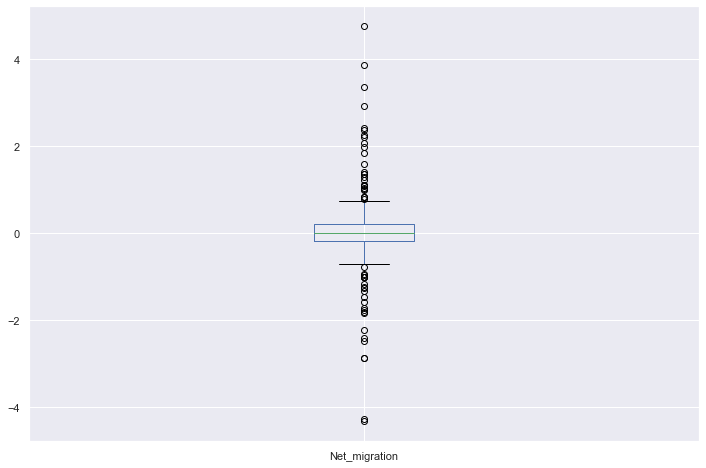

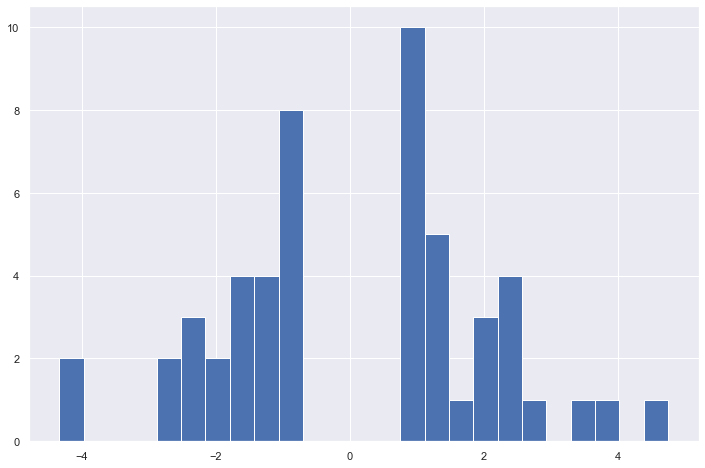

In [70]:
statistics = scaled_countries['Net_migration'].describe()
Q_1 = statistics['25%']
Q_3 = statistics['75%']
IQR = Q_3 - Q_1

outliers = scaled_countries['Net_migration'].loc[(scaled_countries['Net_migration'] < Q_1 - 1.5 * IQR) 
                                          | (scaled_countries['Net_migration'] > Q_3 + 1.5 * IQR)]

outliers_below = scaled_countries['Net_migration'].loc[(scaled_countries['Net_migration'] < Q_1 - 1.5 * IQR)]

outliers_above = scaled_countries['Net_migration'].loc[(scaled_countries['Net_migration'] > Q_3 + 1.5 * IQR)]

scaled_countries[['Net_migration']].boxplot()
fig = plt.figure()
outliers.hist(bins=25);

quartile_boxplot e np.quantile apresentam diferenças ...

In [71]:
x = scaled_countries['Net_migration'].to_numpy()
Q_1, Q_3 = quartile_boxplot(x)
Q_1

-0.19554698037303636

In [72]:
np.quantile(x, 0.25)


-0.19451520210738904

In [73]:
Q_3

0.19652876057294746

In [74]:
np.quantile(x, 0.75)

0.1944652040416528

In [75]:
scaled_countries['Net_migration'].describe()

count    2.270000e+02
mean    -3.912680e-18
std      1.002210e+00
min     -4.339168e+00
25%     -1.945152e-01
50%     -7.763336e-03
75%      1.944652e-01
max      4.750798e+00
Name: Net_migration, dtype: float64

## Newsgroups dataset - Text Analysis

Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:


In [76]:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroups = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)


Quantas vezes as palavras `the` e `phone` aparecem no subdataset utilizado?

In [77]:
count_vectorizer = CountVectorizer()
newsgroups_counts = count_vectorizer.fit_transform(newsgroups.data)
words_idx = sorted([count_vectorizer.vocabulary_.get(f"{word.lower()}") for word in
                    [u"the", u"phone"]])

count_the_phone = pd.DataFrame(newsgroups_counts[:, words_idx].toarray(),
                               columns=np.array(count_vectorizer.get_feature_names())[words_idx])
count_the_phone.sum()

phone      213
the      15247
dtype: int64

Quais as taxas de frequências dos termos `the` e `phone` no subdataset utilizado?

In [78]:
tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(newsgroups_counts)

newsgroups_tfidf = tfidf_transformer.transform(newsgroups_counts)
tfidf_the_phone = pd.DataFrame(newsgroups_tfidf[:, words_idx].toarray(),
                               columns=np.array(count_vectorizer.get_feature_names())[words_idx])
tfidf_the_phone.sum()

phone      8.887746
the      159.222010
dtype: float64

### Questão 6

Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [79]:
def q6():
        
    cv = CountVectorizer(vocabulary=['phone'])
    phone_count = cv.fit_transform(newsgroups.data).toarray().sum()
    
    return phone_count

In [80]:
q6()

213

### Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [81]:
def q7():
    
    count_vectorizer = CountVectorizer()
    newsgroups_counts = count_vectorizer.fit_transform(newsgroups.data)
    
    words_idx = sorted([count_vectorizer.vocabulary_.get(f"{word.lower()}")
                        for word in [u"the", u"phone"]])

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(newsgroups.data)
    
    
    newsgroups_tfidf_vectorized = tfidf_vectorizer.transform(newsgroups.data)
    phone_tfidf = pd.DataFrame(newsgroups_tfidf_vectorized[:, words_idx].toarray(),
                               columns=np.array(count_vectorizer.get_feature_names())[words_idx]).sum().loc['phone'].round(3)
    return phone_tfidf


In [82]:
q7()

8.888

In [83]:
def q7_1():  # NOT WORKING
        
    pipe = Pipeline([('count', TfidfVectorizer(vocabulary=['phone'])),
                  ('tfid', TfidfTransformer())]).fit(newsgroup['data'])
    pipe['count'].transform(newsgroup['data']).toarray()
    X = pipe['tfid'].idf_
       
    
    return round(X[0], 3)